#### Imports & Global Variables

In [1]:
import torch
import pandas as pd
import numpy as np

np.random.seed(42)
torch.manual_seed(42)

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

In [2]:
csv_file_prefix = 'spiral'
# csv_file_prefix = 'two_gaussians'
# csv_file_prefix = 'xor'
# csv_file_prefix = 'center_surround'

batch_size = 32
hidden_size = 64
lr=0.001
num_epochs = 200
lambda_val = 0.003

<br />

# Part 1 and Part 2 and Part 4 -- PyTorch Implementation
---

Implementing and training a FFNN using PyTorch. Each task will utilize the same datasets, but will be handled differently throughout. Anything with the value p1 refers to part 1 variables and p2 refers to part 2 varaibles

*Part 1 implements Multi-class cross entropy as the cost function*

*Part 2 implements Mean-squared error as the cost function*

*Part 4 implements regularization into our model*

---

<br />

### Importing Data

We begin by utilizing PyTorch's torch.utils.data.Dataset object to create a custom dataset that could handle our custom integrations of how to handle the data. For part 1, we simply import the dataset, scale it, and convert it to a torch.tensor(). For part 2, we pass a boolean value for 'one_hot' which will convert the labels into one-hot encoded labels.

Please note that we are only scaling based on the features within the training set to allow for higher accuracy from unseen examples.

In [3]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, df, scaler, one_hot=False, transform=None):
        super().__init__()
        self.features = df.iloc[:, 1:]
        self.labels = df.iloc[:, 0]
        
        self.features = scaler.transform(self.features)

        self.transform = transform
        self.one_hot = one_hot

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        if self.one_hot:
            one_hot_label = F.one_hot(label, num_classes=2).float() # one-hot encoding the labels so we can perform MSELoss on this... tensor([0., 1.])) is 1 and tensor([1., 0.])) is 0
            return feature, one_hot_label
        else:
            return feature, label

In [4]:
scaler = StandardScaler()  # z-score all input features

train_df = pd.read_csv(f'{csv_file_prefix}_train.csv')
valid_df = pd.read_csv(f'{csv_file_prefix}_valid.csv')
test_df = pd.read_csv(f'{csv_file_prefix}_test.csv')

train_features = train_df.iloc[:, 1:]
features = scaler.fit(train_features)

train_dataset_p1 = SimpleDataset(df=train_df, scaler=scaler, one_hot=False)
valid_dataset_p1 = SimpleDataset(df=valid_df, scaler=scaler, one_hot=False)
test_dataset_p1 = SimpleDataset(df=test_df, scaler=scaler, one_hot=False)

train_dataset_p2 = SimpleDataset(df=train_df, scaler=scaler, one_hot=True)
valid_dataset_p2 = SimpleDataset(df=valid_df, scaler=scaler, one_hot=True)
test_dataset_p2 = SimpleDataset(df=test_df, scaler=scaler, one_hot=True)

train_loader_p1 = torch.utils.data.DataLoader(train_dataset_p1, batch_size=batch_size, shuffle=True)
valid_loader_p1 = torch.utils.data.DataLoader(valid_dataset_p1, batch_size=batch_size, shuffle=False)
test_loader_p1 = torch.utils.data.DataLoader(test_dataset_p1, batch_size=batch_size, shuffle=False)

train_loader_p2 = torch.utils.data.DataLoader(train_dataset_p2, batch_size=batch_size, shuffle=True)
valid_loader_p2 = torch.utils.data.DataLoader(valid_dataset_p2, batch_size=batch_size, shuffle=False)
test_loader_p2 = torch.utils.data.DataLoader(test_dataset_p2, batch_size=batch_size, shuffle=False)

### Modeling

We define our simple feed forward network as having one hidden layer with a ReLU activation function. 

We then define our different loss functions and optimization functions below. MCE for part 1 and MSE for part 2. Adam for part 1 and SGD for part 2. 

In [5]:
class SimpleNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.f1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.f2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.f1(x)
        x = self.relu(x)
        x = self.f2(x)
        return x

##### Initializing model / cost function / optimizer

In [6]:
input_size = train_dataset_p1.features.shape[1] 
output_size = len(set(train_dataset_p1.labels))

model_p1_no_reg = SimpleNN(input_size, hidden_size, output_size)
model_p1_with_reg = SimpleNN(input_size, hidden_size, output_size)

model_p2_no_reg = SimpleNN(input_size, hidden_size, output_size)
model_p2_with_reg = SimpleNN(input_size, hidden_size, output_size)

criterion_p1 = torch.nn.CrossEntropyLoss()
criterion_p2 = torch.nn.MSELoss()

optimizer_p1_no_reg = torch.optim.Adam(model_p1_no_reg.parameters(), lr=lr)
optimizer_p1_with_reg = torch.optim.Adam(model_p1_with_reg.parameters(), lr=lr)

optimizer_p2_no_reg = torch.optim.SGD(model_p2_no_reg.parameters(), lr=lr, momentum=0.9)
optimizer_p2_with_reg = torch.optim.SGD(model_p2_with_reg.parameters(), lr=lr, momentum=0.9)

##### Training the model

This function handles the learning aspect of our neural network, such that for each epoch, we run our features through the model to get our predictions, then obtain the loss for this iteration. After computing the loss, we are able to backpropogate through the network to learn the gradients, and then update it for the next step. 

It is important to note at this time that we also use L2-regularization when the boolean value is set to True. L2-regularization is used to increase bias and decrease variance within the model to help limit overfitting the dataset but to help generalize over new examples. 

<div style="text-align: center;">
  <img alt="L2-regularization equation" src="l2_reg.png" />
  <div><i>L2-Regularization</i></div>
</div>


In [7]:
def train(model, train_loader, valid_loader, num_epochs, criterion, optimizer, l2_regularization=False):
    """
    Parameters
    ----------
    model: Pytorch nn.Module model
    train_loader: training set as a DataLoader()
    valid_loader: validation set as a DataLoader()
    num_epochs: Number of epochs
    criterion: Loss function
    optimizer: Optimization function
    l2_regularization: Boolean value representing if you want to use L2-regularization
    """
    
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)

            if l2_regularization:
                reg = lambda_val * torch.sum(model.f1.weight ** 2)
                loss = loss + reg

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_valid_loss = 0.0

        with torch.no_grad():
            for features, labels in valid_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                running_valid_loss += loss.item()

        epoch_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(epoch_valid_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}")
        
    return train_losses, valid_losses

In [8]:
train_losses_p1_no_reg, valid_losses_p1_no_reg = train(model_p1_no_reg, train_loader_p1, valid_loader_p1, num_epochs, criterion_p1, optimizer_p1_no_reg, l2_regularization=False)
train_losses_p1_with_reg, valid_losses_p1_with_reg = train(model_p1_with_reg, train_loader_p1, valid_loader_p1, num_epochs, criterion_p1, optimizer_p1_with_reg, l2_regularization=True)

train_losses_p2_no_reg, valid_losses_p2_no_reg = train(model_p2_no_reg, train_loader_p2, valid_loader_p2, num_epochs, criterion_p2, optimizer_p2_no_reg, l2_regularization=False)
train_losses_p2_with_reg, valid_losses_p2_with_reg = train(model_p2_with_reg, train_loader_p2, valid_loader_p2, num_epochs, criterion_p2, optimizer_p2_with_reg, l2_regularization=True)

Epoch 50/200, Train Loss: 0.4092, Valid Loss: 0.4108
Epoch 100/200, Train Loss: 0.3035, Valid Loss: 0.2984
Epoch 150/200, Train Loss: 0.2064, Valid Loss: 0.1962
Epoch 200/200, Train Loss: 0.1562, Valid Loss: 0.1329
Epoch 50/200, Train Loss: 0.4440, Valid Loss: 0.4067
Epoch 100/200, Train Loss: 0.3542, Valid Loss: 0.3164
Epoch 150/200, Train Loss: 0.2847, Valid Loss: 0.2397
Epoch 200/200, Train Loss: 0.2426, Valid Loss: 0.1786
Epoch 50/200, Train Loss: 0.1421, Valid Loss: 0.1433
Epoch 100/200, Train Loss: 0.1258, Valid Loss: 0.1253
Epoch 150/200, Train Loss: 0.1156, Valid Loss: 0.1097
Epoch 200/200, Train Loss: 0.0947, Valid Loss: 0.0973
Epoch 50/200, Train Loss: 0.2104, Valid Loss: 0.1519
Epoch 100/200, Train Loss: 0.1979, Valid Loss: 0.1398
Epoch 150/200, Train Loss: 0.1858, Valid Loss: 0.1293
Epoch 200/200, Train Loss: 0.1747, Valid Loss: 0.1191


##### Testing the model (with accuracy)

In [9]:
def test_accuracy_p1(model, test_loader):
    """
    Parameters
    ----------
    model: Pytorch nn.Module model
    test_loader: test set as a DataLoader()
    """
    
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)            

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test    
    return test_accuracy

def test_accuracy_p2(model, test_loader):
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for features, one_hot_labels in test_loader:
                outputs = model(features)
                _, predicted = torch.max(outputs, 1)
                
                labels = torch.argmax(one_hot_labels, dim=1)

                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test    
    return test_accuracy

In [10]:
test_accuracy_p1 = test_accuracy_p1(model_p1_no_reg, test_loader_p1)
test_accuracy_p2 = test_accuracy_p2(model_p2_no_reg, test_loader_p2)

print("Test Accuracy (Problem 1): ", test_accuracy_p1)
print("Test Accuracy (Problem 2): ", test_accuracy_p2)

Test Accuracy (Problem 1):  100.0
Test Accuracy (Problem 2):  87.0



### Plotting Loss Curves and Decision Boundaries

*Please note that ChatGPT was utilized for the plots. We originally made our own version based on the decision boundary code you left for us in example.ipynb. But decided that rather than 4 individual plots each time, that it may be cleaner if expressed in a 2x2 fig, ax plot. So we did have ChatGPT quickly create these plots for us for the purpose of making the data easier to understand. We only chose to do this because we thought that the plots were not the focus of the homework, but were just the way to show the viewer what our own code actually learned.*

In [11]:
def plot_loss_curves_2x2_fixed(train_losses, 
                               valid_losses,
                               titles):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.plot(list(range(1, num_epochs + 1)), train_losses[i], label='train loss')
        ax.plot(list(range(1, num_epochs + 1)), valid_losses[i], label='valid loss')
        ax.set_title(f'Loss Curves ({titles[i]})')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    plt.tight_layout()
    plt.show()


def plot_decision_boundaries_2x2_fixed(models,
                                       loaders,
                                       titles,
                                       encoding_flags):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        model = models[i]
        train_loader = loaders[i]
        title = titles[i]
        encode = encoding_flags[i]

        y_min, y_max = train_loader.dataset.features[:, 1].min(), train_loader.dataset.features[:, 1].max()
        x_min, x_max = train_loader.dataset.features[:, 0].min(), train_loader.dataset.features[:, 0].max()
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

        grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
        with torch.no_grad():
            Z = model(grid_points) 
            Z = Z.argmax(dim=1).numpy()

        Z = Z.reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')

        for inputs, label in train_loader:
            inputs = inputs.numpy()
            labels = label.numpy()
            if encode:
                labels = label.argmax(dim=1).numpy()
            ax.scatter(inputs[:, 0], inputs[:, 1], c=labels, edgecolor='k', cmap='coolwarm', marker='o')

        ax.set_title(title)
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")

    plt.tight_layout()
    plt.show()

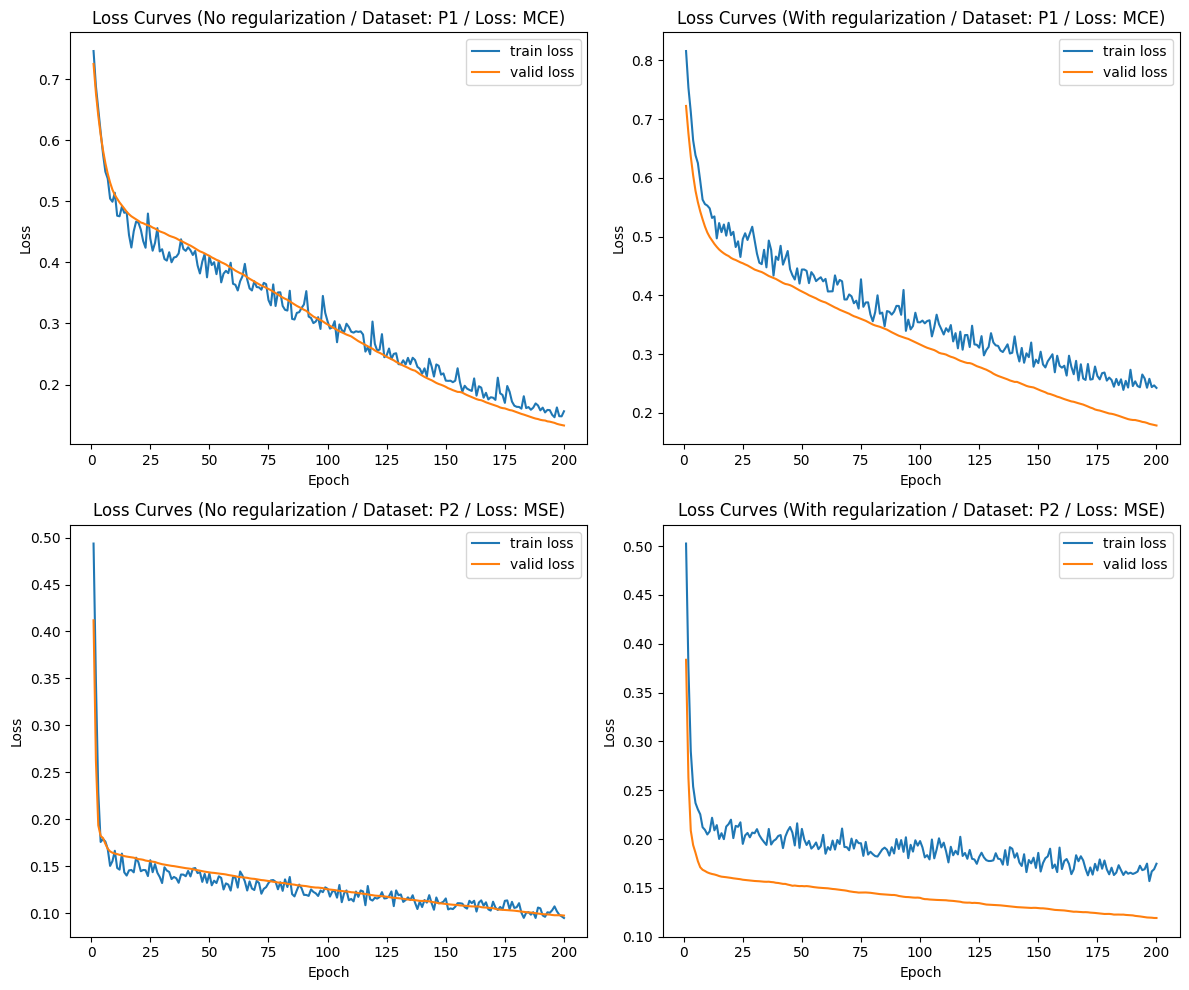

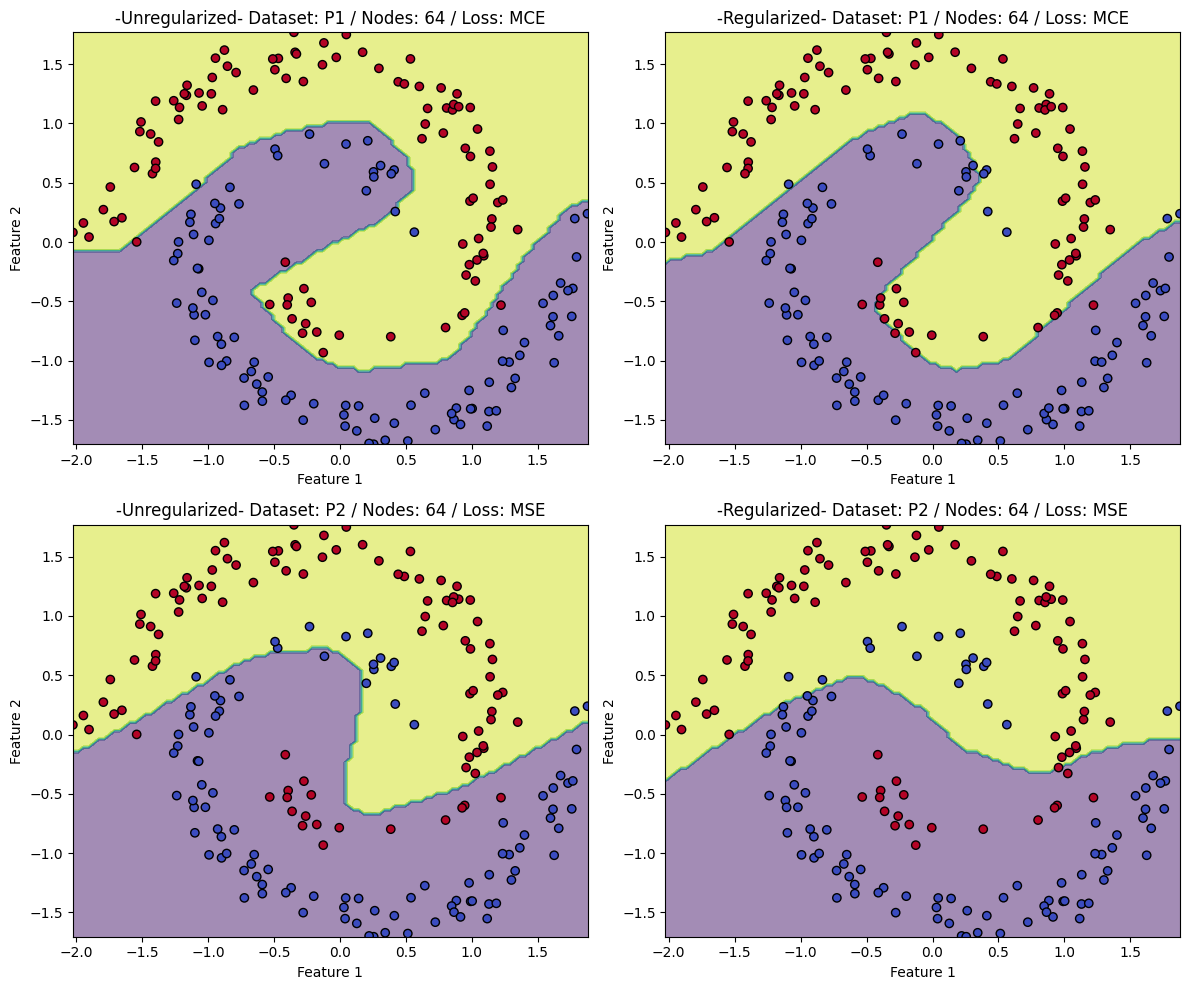

In [12]:
# Loss curves

train_losses = [
    train_losses_p1_no_reg, train_losses_p1_with_reg, 
    train_losses_p2_no_reg, train_losses_p2_with_reg
]
valid_losses = [
    valid_losses_p1_no_reg, valid_losses_p1_with_reg, 
    valid_losses_p2_no_reg, valid_losses_p2_with_reg
]
titles = [
    "No regularization / Dataset: P1 / Loss: MCE",
    "With regularization / Dataset: P1 / Loss: MCE",
    "No regularization / Dataset: P2 / Loss: MSE",
    "With regularization / Dataset: P2 / Loss: MSE"
]

plot_loss_curves_2x2_fixed(
    train_losses,
    valid_losses,
    titles
)

# Decision Boudaries

models = [model_p1_no_reg, model_p1_with_reg, model_p2_no_reg, model_p2_with_reg]
loaders = [train_loader_p1, train_loader_p1, train_loader_p2, train_loader_p2]
titles = [
    f"-Unregularized- Dataset: P1 / Nodes: {hidden_size} / Loss: MCE",
    f"-Regularized- Dataset: P1 / Nodes: {hidden_size} / Loss: MCE",
    f"-Unregularized- Dataset: P2 / Nodes: {hidden_size} / Loss: MSE",
    f"-Regularized- Dataset: P2 / Nodes: {hidden_size} / Loss: MSE"
]
encoding_flags = [False, False, True, True]

plot_decision_boundaries_2x2_fixed(
    models,
    loaders,
    titles,
    encoding_flags
)

<br />
<br />
<br />
<br />
<br />

# Part 3 -- Neural Network From Scratch

# IMPORTS

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

np.random.seed(42)

# DEFINE STATIC FUNCTIONS

In [ ]:
def z_score(df, scaler):
    """Z-scores the feature values based on the input scalar and returns the scaled features and the labels

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with labels in the first column and features in following columns
    scaler : sklearn.preprocessing.StandardScaler
        Scaler fit to the training dataset feature values

    Returns
    -------
    tuple
        np.array of scaled features and np.array of labels
    """
    features = df.iloc[:, 1:]
    labels = df.iloc[:, 0].values

    features = scaler.transform(features)
    return features, labels

def label_encoder(labels):
    """Creates a one-hot encoding (dictionary) for the input labels

    Parameters
    ----------
    labels : np.array
        Array of training dataset labels

    Returns
    -------
    dict
        Dictionary with "numerical encoding: label" key: value pairs
    """
    unique_labels = sorted(np.unique(labels))
    labels_encoding = {i: l for i, l in enumerate(unique_labels)}
    return labels_encoding

def encode_labels(labels, encoder):
    """Encodes input labels using the input encoder

    Parameters
    ----------
    labels : np.array
        Array of training dataset labels
    encoder : dict
        Dictionary with "numerical encoding: label" key: value pairs

    Returns
    -------
    np.array
        Array of encoded labels
    """
    return np.array([encoder[l] for l in labels])

def decode_labels(encoded_labels, encoder):
    """Decodes encoded labels using the input encoder

    Parameters
    ----------
    encoded_labels : np.array
        Array of encoded labels
    encoder : dict
        Dictionary with "numerical encoding: label" key: value pairs

    Returns
    -------
    np.array
        Array of decoded labels
    """
    decoder = {value: key for key, value in encoder.items()}
    return np.array([decoder[l] for l in encoded_labels])

def encoded_labels_array(encoded_labels):
    """Transforms encoded labels into label arrays (e.g., encoded label 1 becomes [0, 1] and encoded label 0 becomes [1, 0],
    assuming binary classification)

    Parameters
    ----------
    encoded_labels : np.array
        Array of encoded labels

    Returns
    -------
    np.array
        Array of encoded labels as arrays
    """
    num_unique_labels = len(np.unique(encoded_labels))
    return np.array([np.array([1 if i == el else 0 for i in range(num_unique_labels)]) for el in encoded_labels])

In [ ]:
def softmax(logits):
    """Performs the softmax operation on the input logits

    Parameters
    ----------
    logits : np.array
        Array of logits (raw output from output layer)

    Returns
    -------
    np.array
        Array of values after performing softmax (values sum to 1)
    """
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

def mcce(softmax_logits, labels):
    """Calculates multi-class cross entropy loss based on the softmaxed logits (class probabilities) and true labels

    Parameters
    ----------
    softmax_logits : np.array
        Array of softmaxed logits (class probabilities)
    labels : np.array
        Array of true labels 

    Returns
    -------
    np.float64
        Multi-class cross entropy loss
    """
    return - np.sum(labels * np.log(softmax_logits))

def sigmoid(unactivated):
    """Performs the sigmoid operation on the unactivated input matrix (output matrix from last layer @ weights)

    Parameters
    ----------
    unactivated : np.array
        Unactivated input matrix (output matrix from last layer @ weights)

    Returns
    -------
    np.array
        Matrix after performing sigmoid operation on unactivated input matrix
    """
    return 1 / (1 + np.exp(-unactivated))

def sigmoid_derivative(activated):
    """Performs the sigmoid derivative operation on the activated input matrix

    Parameters
    ----------
    activated : np.array
        Activated input matrix

    Returns
    -------
    np.array
        Matrix after performing sigmoid derivative operation on activated input matrix
    """
    return sigmoid(activated) * (1 - sigmoid(activated))

def relu(unactivated):
    """Performs the relu operation on the unactivated input matrix (output matrix from last layer @ weights)

    Parameters
    ----------
    unactivated : np.array
        Unactivated input matrix (output matrix from last layer @ weights)

    Returns
    -------
    np.array
        Matrix after performing relu operation on unactivated input matrix
    """
    return np.maximum(0, unactivated)

def relu_derivative(activated):
    """Performs the relu derivative operation on the activated input matrix

    Parameters
    ----------
    activated : np.array
        Activated input matrix

    Returns
    -------
    np.array
        Matrix after performing relu derivative operation on activated input matrix
    """
    return (activated > 0).astype(float)

# EXPLORE DOT PRODUCT RESULTS WITH MULTIPLE EXAMPLES

In [ ]:
np.ones((2, 10))

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
np.ones((32, 2))

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [ ]:
((np.ones((32, 2)) * 1) @ (np.ones((2, 32)) * 2)).shape

(32, 32)

In [ ]:
((np.ones((32, 2)) * 1) @ (np.ones((2, 32)) * 2)) + np.ones(32)

array([[5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       ...,
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.],
       [5., 5., 5., ..., 5., 5., 5.]])

# TEST SOFTMAX AND MCCE 

In [ ]:
arr = [[-2, 3, 2]]
sm = softmax(arr)
sm, sum(sm[0]), mcce(sm, [[0, 0, 1]]), mcce(sm, [[1, 0, 0]]), mcce(sm, [[0, 1, 0]])

(array([[0.00490169, 0.72747516, 0.26762315]]),
 np.float64(1.0),
 np.float64(1.318175429247454),
 np.float64(5.318175429247454),
 np.float64(0.31817542924745396))

# CREATE MODEL OBJECT

In [ ]:
class model:
    """An object representing a trainable neural network with the follow architecture:
    Input Layer (input_size inputs)
        |
        v
    Weights (w_i_h) + Biases (b_i_h)
        |
        v
    ReLU Activation Function
        |
        v
    Hidden Layer (hidden_size hidden units)
        |
        v
    Weights (w_h_o) + Biases (b_h_o)
        |
        v
    Softmax Activation Function
        |
        v
    Output Layer (output_size outputs)
    """
    def __init__(self, input_size=2, hidden_size=9, output_size=2):
        """Initializes a neural network with specified input_size, hidden_size, and output_size (number of classes)
        by setting weights to values sampled from a normal distribution and biases to zero

        Parameters
        ----------
        input_size : int, optional
            Number of input features, by default 2
        hidden_size : int, optional
            Number of nodes in hidden layer, by default 9
        output_size : int, optional
            Number of output features (classes), by default 2
        """
        shape_i_h = (input_size, hidden_size) # shape of input to hidden layer weights matrix
        shape_h_o = (hidden_size, output_size) # shape of hidden to output layer weights matrix

        self.w_i_h = np.random.normal(loc=0.0, scale=1.0, size=shape_i_h) # randomly sample unique weights from a gaussian dist with mean 0 and std 1
        self.w_h_o = np.random.normal(loc=0.0, scale=1.0, size=shape_h_o) # randomly sample unique weights from a gaussian dist with mean 0 and std 1

        self.b_i_h = np.zeros(shape=(1, hidden_size)) # set biases to zero
        self.b_h_o = np.zeros(shape=(1, output_size)) # set biases to zero

        self.num_params = input_size * hidden_size + hidden_size * output_size + hidden_size + output_size # calculate number of params for fun

    def forward(self, features, train=False):
        """Perform a forward pass through the neural network

        Parameters
        ----------
        features : np.array
            Array of examples with each example being an array of feature values
        train : bool, optional
            True if training the network (i.e., if intermediate results are needed to compute gradients), by default False

        Returns
        -------
        np.array
            Array of outputs for each example with each output being an array of class probabilities
        """
        forward_results = {}

        forward_results['features'] = features
        i_h = features @ self.w_i_h
        forward_results['i_h'] = i_h
        i_h_b = i_h + self.b_i_h
        forward_results['i_h_b'] = i_h_b
        a_i_h_b = relu(i_h_b)
        forward_results['a_i_h_b'] = a_i_h_b        

        h_o = a_i_h_b @ self.w_h_o
        forward_results['h_o'] = h_o        
        h_o_b = h_o + self.b_h_o
        forward_results['h_o_b'] = h_o_b
        a_h_o_b = softmax(h_o_b)
        forward_results['a_h_o_b'] = a_h_o_b

        if train:
            return a_h_o_b, forward_results
        return a_h_o_b

    def backward(self, forward_results, labels):
        """Perform backpropagation through the neural network

        Parameters
        ----------
        forward_results : dict
            Dictionary of all results (input, intermediates, and output) from forward a pass
        labels : np.array
            Array of encoded labels

        Returns
        -------
        dict
            Dictionary of gradient matrices of weight and bias matrices
        """
        gradients = {}
        
        probs = forward_results['a_h_o_b']
        
        dL_dh_o_b = probs - labels
        
        a_i_h_b = forward_results['a_i_h_b']
        gradients['w_h_o'] = a_i_h_b.T @ dL_dh_o_b
        gradients['b_h_o'] = np.sum(dL_dh_o_b, axis=0, keepdims=True)

        dL_da_i_h_b = dL_dh_o_b @ self.w_h_o.T 
        dL_di_h_b = dL_da_i_h_b * relu_derivative(forward_results['a_i_h_b'])

        gradients['w_i_h'] = forward_results['features'].T @ dL_di_h_b 
        gradients['b_i_h'] = np.sum(dL_di_h_b, axis=0, keepdims=True)

        return gradients
        
    def update_weights(self, gradients, learning_rate):
        """Updates the model weight and bias matrices based on the gradients and learning rate

        Parameters
        ----------
        gradients : dict
            Dictionary of gradient matrices of weight and bias matrices
        learning_rate : float
            A scalar that controls the size of the step taken during the update
        """
        self.w_h_o -= (learning_rate * gradients['w_h_o'])
        self.b_h_o -= (learning_rate * gradients['b_h_o'])
        self.w_i_h -= (learning_rate * gradients['w_i_h'])
        self.b_i_h -= (learning_rate * gradients['b_i_h'])

    def train(self, features, encoded_labels, valid_features, encoded_valid_labels, num_epochs, learning_rate):
        """Trains the model for the number of specified epochs over the training data and computes loss after 
        each epoch for the training and validation datasets

        Parameters
        ----------
        features : np.array
            Array of examples with each example being an array of feature values
        encoded_labels : np.array
            Array of encoded labels
        valid_features : np.array
            Array of validation examples with each example being an array of feature values
        encoded_valid_labels : np.array
            Array of encoded validation labels
        num_epochs : int
            The number of complete passes over the training dataset to take during training
        learning_rate : float
            A scalar that controls the size of the step taken during the update

        Returns
        -------
        tuple
            List of train losses for each epoch and list of validation losses for each epoch
        """
        encoded_labels_arr = encoded_labels_array(encoded_labels)
        encoded_valid_labels_arr = encoded_labels_array(encoded_valid_labels)

        train_loss = []
        valid_loss = []
        
        for i in range(num_epochs):
            probs, forward_results = self.forward(features, train=True)
            
            gradients = self.backward(forward_results, encoded_labels_arr)
            # for k, v in gradients.items():
            #     print(f'{k}: {v.shape}')
            
            self.update_weights(gradients, learning_rate)
            
            loss = mcce(forward_results['a_h_o_b'], encoded_labels_arr)
            train_loss.append(loss)

            probs, forward_results = self.forward(valid_features, train=True)
                                    
            loss = mcce(forward_results['a_h_o_b'], encoded_valid_labels_arr)
            valid_loss.append(loss)
        
        return train_loss, valid_loss
    
    def predict(self, features):
        """Predicts encoded labels for the inputed examples

        Parameters
        ----------
        features : np.array
            Array of examples with each example being an array of feature values

        Returns
        -------
        np.array
            Array of predicted encoded labels
        """
        y_predicted = self.forward(features)
        predicted_labels = np.array([np.argmax(y_p) for y_p in y_predicted])
        return predicted_labels
    
    def accuracy(self, test_features, encoded_test_labels):
        """Calculates the classification accuracy of the model on the input test dataset

        Parameters
        ----------
        test_features : np.array
            Array of test examples with each example being an array of feature values
        encoded_test_labels : np.array
            Array of encoded test labels

        Returns
        -------
        float
            Accuracy score
        """
        test_results = self.predict(test_features)
        acc = np.sum([test_result == encoded_test_label for test_result, encoded_test_label in zip(test_results, encoded_test_labels)]) / len(encoded_test_labels)
        return acc
    
    def decision_boundary(self, train_features, encoded_train_labels):
        """Generates a plot showcasing the decision boundary of the model and the training datapoints

        Parameters
        ----------
        train_features : np.array
            Array of training examples with each example being an array of feature values
        encoded_train_labels : np.array
            Array of encoded training labels
        """
        x_min, x_max = train_features[:, 0].min() - 1, train_features[:, 0].max() + 1
        y_min, y_max = train_features[:, 1].min() - 1, train_features[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

        # Predict labels for all points in the meshgrid
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        Z = self.predict(grid_points)
        Z = Z.reshape(xx.shape)

        # Plot decision boundary
        plt.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')

        # Scatter plot of training points
        plt.scatter(train_features[:, 0], train_features[:, 1], c=encoded_train_labels, edgecolor='k', cmap='coolwarm', marker='o')

        plt.title("Decision Boundary with Training Data Points")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.show()

# TEST FORWARD

In [ ]:
i = np.ones((1, 2))
i_multiple = np.ones((16, 2))

In [ ]:
m = model()
m.forward(i), m.forward(i_multiple).shape

(array([[0.05434576, 0.94565424]]), (16, 2))

# TEST BACKPROP

In [ ]:
_, results = m.forward(i_multiple, True)
m.backward(results, np.ones((16, 2)))

{'w_h_o': array([[-15.72470473,  -0.90368242],
        [  0.        ,   0.        ],
        [ -2.75312152,  -0.15821903],
        [-26.70515649,  -1.53471756],
        [  0.        ,   0.        ],
        [  0.        ,   0.        ],
        [-15.38655526,  -0.88424932],
        [  0.        ,   0.        ],
        [  0.        ,   0.        ]]),
 'b_h_o': array([[-15.13046776,  -0.86953224]]),
 'w_i_h': array([[14.9668726 ,  0.        ,  0.21713116,  8.1403145 ,  0.        ,
          0.        ,  7.4934869 ,  0.        ,  0.        ],
        [14.9668726 ,  0.        ,  0.21713116,  8.1403145 ,  0.        ,
          0.        ,  7.4934869 ,  0.        ,  0.        ]]),
 'b_i_h': array([[14.9668726 ,  0.        ,  0.21713116,  8.1403145 ,  0.        ,
          0.        ,  7.4934869 ,  0.        ,  0.        ]])}

# PREPROCESS DATASET: spiral

In [ ]:
csv_file_prefix = 'spiral'

In [ ]:
scaler = StandardScaler()  # z-score all input features

train_df = pd.read_csv(f'{csv_file_prefix}_train.csv')

train_features = train_df.iloc[:, 1:]
features = scaler.fit(train_features)

valid_df = pd.read_csv(f'{csv_file_prefix}_valid.csv')
test_df = pd.read_csv(f'{csv_file_prefix}_test.csv')

train_features, train_labels = z_score(train_df, scaler)
train_labels_encoder = label_encoder(train_labels)
encoded_train_labels = encode_labels(train_labels, train_labels_encoder)

valid_features, valid_labels = z_score(valid_df, scaler)
valid_labels_encoder = label_encoder(valid_labels)
encoded_valid_labels = encode_labels(valid_labels, valid_labels_encoder)

test_features, test_labels = z_score(test_df, scaler)
test_labels_encoder = label_encoder(test_labels)
encoded_test_labels = encode_labels(test_labels, test_labels_encoder)

In [ ]:
train_features

array([[-2.77791563e-01,  1.35395746e+00],
       [ 1.67274789e+00, -3.45859511e-01],
       [-4.93735018e-01,  1.45352085e+00],
       [-4.67327018e-01,  1.54910559e+00],
       [ 1.39855047e+00, -8.47922756e-01],
       [ 1.28268434e+00, -1.01267747e+00],
       [-4.00262601e-01, -5.30592602e-01],
       [-3.30490868e-01,  1.58647076e+00],
       [-3.63258727e-01, -6.47713114e-01],
       [-1.39811858e+00,  1.18857006e+00],
       [ 9.78624757e-01, -1.25146899e+00],
       [-1.27022071e-01, -9.32982958e-01],
       [-3.93097549e-01, -4.72506863e-01],
       [-1.99151036e-01, -1.36354015e+00],
       [-1.42185427e+00,  5.76747404e-01],
       [ 9.87598576e-01,  1.13456030e+00],
       [ 8.99844197e-01,  1.14164156e+00],
       [-1.65346982e+00,  2.04701797e-01],
       [-1.22433690e+00,  1.13403462e-03],
       [ 1.27278916e-01, -1.59315768e+00],
       [ 8.82153287e-01, -1.40075931e+00],
       [ 5.38300823e-01, -1.37647378e+00],
       [-8.99353962e-01, -8.61963591e-01],
       [ 8.

In [ ]:
encoded_labels_array(encoded_train_labels)

array([[0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1,

# INSTANTIATE AND TRAIN MODEL

In [ ]:
m = model(input_size=len(train_features[0]), hidden_size=9, output_size=len(np.unique(train_labels)))

num_epochs = 1000
learning_rate = 0.001
train_loss, valid_loss = m.train(train_features, encoded_train_labels, valid_features, encoded_valid_labels, num_epochs, learning_rate)

In [ ]:
m.w_i_h

array([[ 0.5677986 , -2.27787594, -1.4492415 ,  0.3767449 ,  1.88108795,
         0.48720078,  0.69668074, -0.64412203, -2.22875251],
       [-1.13864049, -0.17725133,  1.03222827,  1.24456077, -2.14456783,
         1.60677266, -1.85752208, -2.07939978,  1.09404801]])

In [ ]:
m.b_i_h

array([[-0.53109221, -0.04195683, -1.51115576, -0.91759589, -1.78665572,
        -1.18480933,  0.85525345, -1.08391258, -2.16365512]])

# PLOT LOSS CURVES

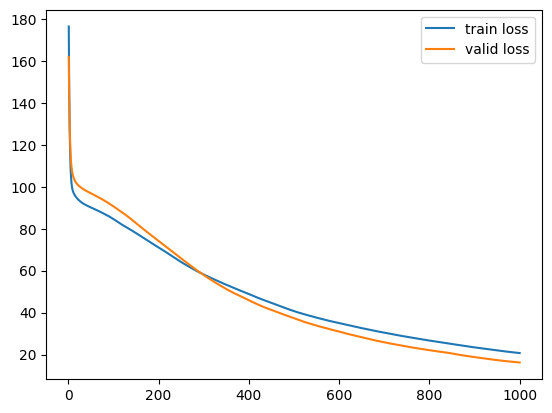

In [ ]:
plt.plot(range(1, num_epochs + 1), train_loss, label='train loss')
plt.plot(range(1, num_epochs + 1), valid_loss, label='valid loss')
plt.legend()

plt.show()

# COMPUTE TEST ACCURACY

In [ ]:
m.accuracy(test_features, encoded_test_labels)

np.float64(1.0)

# PLOT DECISION BOUNDARY

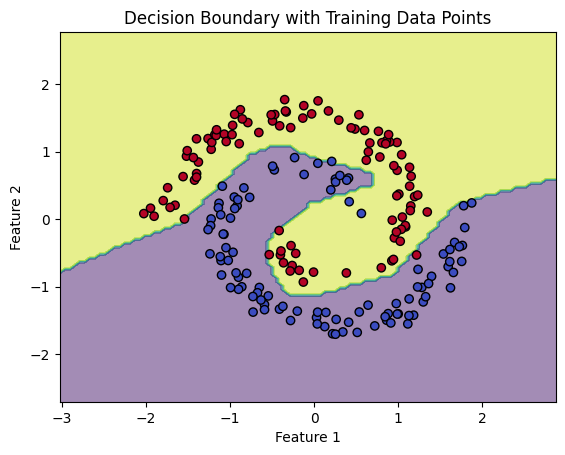

In [ ]:
m.decision_boundary(train_features, encoded_train_labels)

# PREPROCESS DATASET: two_gaussians

In [ ]:
csv_file_prefix = 'two_gaussians'

In [ ]:
scaler = StandardScaler()  # z-score all input features

train_df = pd.read_csv(f'{csv_file_prefix}_train.csv')

train_features = train_df.iloc[:, 1:]
features = scaler.fit(train_features)

valid_df = pd.read_csv(f'{csv_file_prefix}_valid.csv')
test_df = pd.read_csv(f'{csv_file_prefix}_test.csv')

train_features, train_labels = z_score(train_df, scaler)
train_labels_encoder = label_encoder(train_labels)
encoded_train_labels = encode_labels(train_labels, train_labels_encoder)

valid_features, valid_labels = z_score(valid_df, scaler)
valid_labels_encoder = label_encoder(valid_labels)
encoded_valid_labels = encode_labels(valid_labels, valid_labels_encoder)

test_features, test_labels = z_score(test_df, scaler)
test_labels_encoder = label_encoder(test_labels)
encoded_test_labels = encode_labels(test_labels, test_labels_encoder)

In [ ]:
train_features

array([[-4.84458188e-01,  9.06105900e-01],
       [-1.41189982e+00, -8.99473739e-01],
       [ 6.91203255e-01,  2.25489728e+00],
       [ 7.53527620e-01,  7.79626494e-01],
       [-2.61862616e-01, -1.20409996e+00],
       [ 8.11361757e-01,  1.40072317e+00],
       [ 4.05026054e-01,  3.73417908e-01],
       [ 8.90270032e-01,  1.27418333e+00],
       [-1.68041546e+00, -1.50618814e+00],
       [-4.70867764e-01, -4.68307678e-01],
       [-1.76076061e+00,  3.07368223e-01],
       [ 2.19370091e-01,  4.66842257e-01],
       [ 1.30845994e+00,  6.36347625e-01],
       [-1.62874790e+00, -4.40751725e-01],
       [-8.12484314e-01, -1.66143209e+00],
       [ 1.88716053e+00, -2.39679382e-02],
       [-1.31389311e+00, -5.59556557e-01],
       [ 6.08351064e-02, -3.67571333e-01],
       [ 8.23156090e-01,  1.57935342e+00],
       [ 1.35611622e+00,  9.20306885e-01],
       [-1.32395122e+00,  4.41220055e-01],
       [ 1.43466528e+00,  6.38100087e-01],
       [-7.61535193e-01,  3.08032950e-01],
       [-1.

In [ ]:
encoded_labels_array(encoded_train_labels)

array([[0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1,

# INSTANTIATE AND TRAIN MODEL

In [ ]:
m = model(input_size=len(train_features[0]), hidden_size=9, output_size=len(np.unique(train_labels)))

num_epochs = 1000
learning_rate = 0.001
train_loss, valid_loss = m.train(train_features, encoded_train_labels, valid_features, encoded_valid_labels, num_epochs, learning_rate)

In [ ]:
m.w_i_h

array([[ 0.2692922 ,  2.10531873, -2.62032579,  0.71566538, -0.10026296,
        -0.3413273 ,  0.05382448, -2.08221327, -0.70009884],
       [ 0.63426966,  1.4456016 , -1.34524685, -0.91561353, -0.83903596,
         1.04637567,  0.2612508 , -0.3266646 ,  0.18214068]])

In [ ]:
m.b_i_h

array([[ 0.13380193, -0.20309245, -0.33546789,  0.06308565,  0.05224654,
        -0.0116906 , -0.10167537,  0.2489353 , -0.2455829 ]])

# PLOT LOSS CURVES

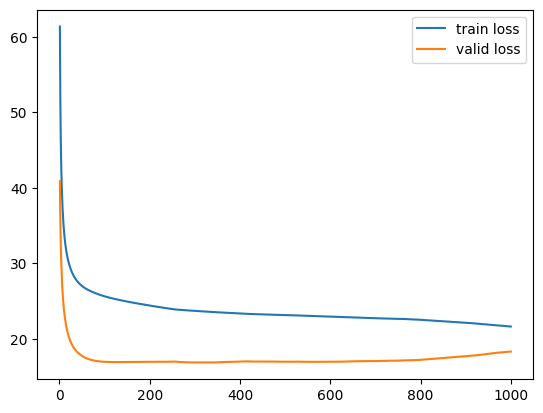

In [ ]:
plt.plot(range(1, num_epochs + 1), train_loss, label='train loss')
plt.plot(range(1, num_epochs + 1), valid_loss, label='valid loss')
plt.legend()

plt.show()

# COMPUTE TEST ACCURACY

In [ ]:
m.accuracy(test_features, encoded_test_labels)

np.float64(0.91)

# PLOT DECISION BOUNDARY

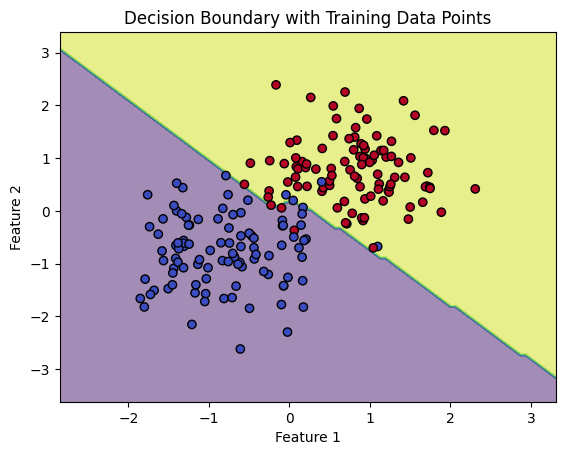

In [ ]:
m.decision_boundary(train_features, encoded_train_labels)

# PREPROCESS DATASET: xor

In [ ]:
csv_file_prefix = 'xor'

In [ ]:
scaler = StandardScaler()  # z-score all input features

train_df = pd.read_csv(f'{csv_file_prefix}_train.csv')

train_features = train_df.iloc[:, 1:]
features = scaler.fit(train_features)

valid_df = pd.read_csv(f'{csv_file_prefix}_valid.csv')
test_df = pd.read_csv(f'{csv_file_prefix}_test.csv')

train_features, train_labels = z_score(train_df, scaler)
train_labels_encoder = label_encoder(train_labels)
encoded_train_labels = encode_labels(train_labels, train_labels_encoder)

valid_features, valid_labels = z_score(valid_df, scaler)
valid_labels_encoder = label_encoder(valid_labels)
encoded_valid_labels = encode_labels(valid_labels, valid_labels_encoder)

test_features, test_labels = z_score(test_df, scaler)
test_labels_encoder = label_encoder(test_labels)
encoded_test_labels = encode_labels(test_labels, test_labels_encoder)

In [ ]:
train_features

array([[-7.70456523e-01,  8.76493383e-01],
       [ 7.06498327e-01,  2.66823092e-02],
       [-4.56966795e-01, -1.66068960e+00],
       [ 1.68092581e+00, -1.68531209e-01],
       [-3.96545074e-01, -1.35917560e+00],
       [-1.33322055e+00, -1.18451087e+00],
       [-1.75862370e-01,  6.91257884e-01],
       [-6.22362236e-02,  5.17778665e-01],
       [-1.72748847e+00, -1.47515772e+00],
       [ 8.49271246e-01,  1.25111366e+00],
       [-1.04711954e+00,  1.80711653e+00],
       [-2.73851043e-01,  9.60170433e-01],
       [-1.17198708e-01,  7.72069958e-01],
       [ 1.47597311e+00, -5.34382187e-02],
       [-1.54488071e-01,  1.93716815e-02],
       [ 1.03007376e+00, -6.83535293e-01],
       [-8.63726194e-01, -4.66291099e-01],
       [ 1.03627323e+00,  1.16911608e+00],
       [-1.39358583e-02,  1.66870857e+00],
       [ 6.97245383e-01,  1.46312186e+00],
       [-1.07298059e-01,  9.51453497e-02],
       [ 1.30044477e+00, -4.50583129e-01],
       [ 8.88133608e-01, -1.18470846e+00],
       [-1.

In [ ]:
encoded_labels_array(encoded_train_labels)

array([[1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0,

# INSTANTIATE AND TRAIN MODEL

In [ ]:
m = model(input_size=len(train_features[0]), hidden_size=9, output_size=len(np.unique(train_labels)))

num_epochs = 1000
learning_rate = 0.001
train_loss, valid_loss = m.train(train_features, encoded_train_labels, valid_features, encoded_valid_labels, num_epochs, learning_rate)

In [ ]:
m.w_i_h

array([[-0.43067205, -2.16107285, -1.65492371,  0.89218153, -1.89026352,
         2.75876005,  2.37226899,  0.80803667,  1.10158697],
       [-1.27271472,  2.69161521,  0.36558029,  0.88860981, -2.21261952,
         1.90640283, -2.35418767,  0.76745139,  2.09768239]])

In [ ]:
m.b_i_h

array([[-0.0420061 ,  0.26532021, -0.23057185, -0.19399031,  0.26654351,
        -0.05401203, -0.26348168, -0.18253729, -0.19712008]])

# PLOT LOSS CURVES

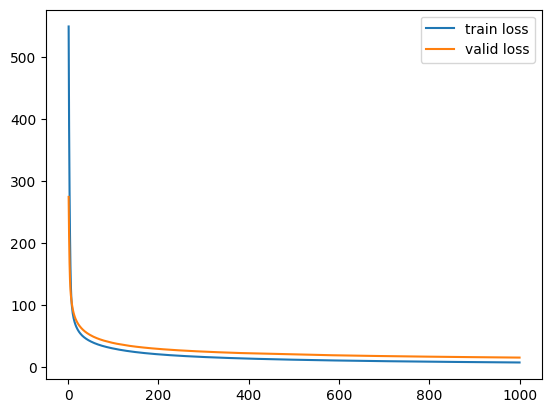

In [ ]:
plt.plot(range(1, num_epochs + 1), train_loss, label='train loss')
plt.plot(range(1, num_epochs + 1), valid_loss, label='valid loss')
plt.legend()

plt.show()

# COMPUTE TEST ACCURACY

In [ ]:
m.accuracy(test_features, encoded_test_labels)

np.float64(0.995)

# PLOT DECISION BOUNDARY

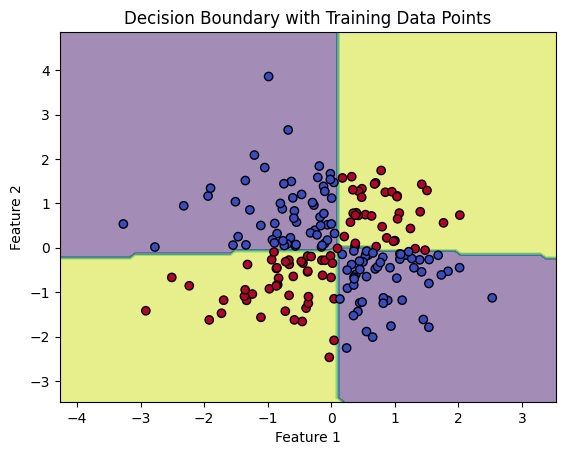

In [ ]:
m.decision_boundary(train_features, encoded_train_labels)

# PREPROCESS DATASET: center_surround

In [ ]:
csv_file_prefix = 'center_surround'

In [ ]:
scaler = StandardScaler()  # z-score all input features

train_df = pd.read_csv(f'{csv_file_prefix}_train.csv')

train_features = train_df.iloc[:, 1:]
features = scaler.fit(train_features)

valid_df = pd.read_csv(f'{csv_file_prefix}_valid.csv')
test_df = pd.read_csv(f'{csv_file_prefix}_test.csv')

train_features, train_labels = z_score(train_df, scaler)
train_labels_encoder = label_encoder(train_labels)
encoded_train_labels = encode_labels(train_labels, train_labels_encoder)

valid_features, valid_labels = z_score(valid_df, scaler)
valid_labels_encoder = label_encoder(valid_labels)
encoded_valid_labels = encode_labels(valid_labels, valid_labels_encoder)

test_features, test_labels = z_score(test_df, scaler)
test_labels_encoder = label_encoder(test_labels)
encoded_test_labels = encode_labels(test_labels, test_labels_encoder)

In [ ]:
train_features

array([[-1.36846388,  1.54362905],
       [ 0.13476095, -0.35808876],
       [-1.17397245,  2.0546884 ],
       [ 0.12212715, -0.3837286 ],
       [-0.08095132, -1.53810042],
       [-0.62721513,  1.00950964],
       [-0.0480837 ,  0.83924427],
       [ 0.87181488,  1.14860707],
       [ 0.01281516,  1.13870915],
       [-0.88601064, -0.04488261],
       [ 0.36024467,  0.65818595],
       [-1.07364231,  0.34598012],
       [ 1.22842364,  0.88420612],
       [-0.34601437,  0.40926367],
       [-0.1268969 , -1.02388216],
       [ 0.11358946,  0.30828377],
       [ 2.06778174, -0.46954571],
       [ 0.30610686, -0.15128531],
       [-0.14683462, -0.27295608],
       [-0.3318507 ,  0.36735543],
       [ 0.24565216,  1.120756  ],
       [ 0.10544658,  0.28938295],
       [ 1.20093525, -0.9794468 ],
       [ 1.31212256,  0.16818602],
       [-0.90101327, -1.43443545],
       [-0.82486502, -0.23652329],
       [ 1.65155724,  1.13565553],
       [ 0.75894964, -0.38683486],
       [-0.60323065,

In [ ]:
encoded_labels_array(encoded_train_labels)

array([[0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1,

# INSTANTIATE AND TRAIN MODEL

In [ ]:
m = model(input_size=len(train_features[0]), hidden_size=9, output_size=len(np.unique(train_labels)))

num_epochs = 1000
learning_rate = 0.001
train_loss, valid_loss = m.train(train_features, encoded_train_labels, valid_features, encoded_valid_labels, num_epochs, learning_rate)

In [ ]:
m.w_i_h

array([[-0.14729877,  0.76313023, -2.01100829, -1.23226142,  1.16684091,
        -0.31443228,  0.97367613,  1.13272327, -1.27041698],
       [ 0.33939576,  0.20116255, -0.48836037,  1.91555841,  0.9450029 ,
        -1.48691932,  1.22182722, -1.41765725,  1.38773829]])

In [ ]:
m.b_i_h

array([[ 1.60324355, -0.02601457, -0.15675138,  0.01796495, -0.47284248,
        -0.29638873,  0.02575037, -0.73518412, -0.48749397]])

# PLOT LOSS CURVES

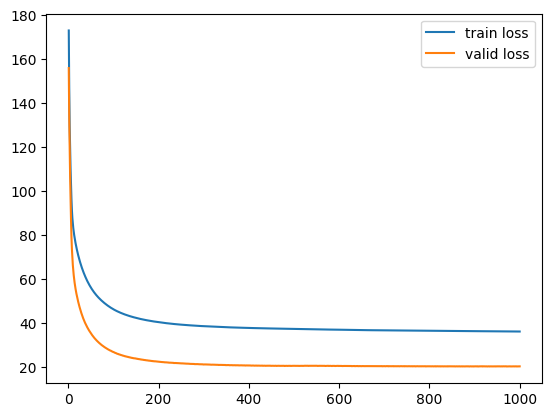

In [ ]:
plt.plot(range(1, num_epochs + 1), train_loss, label='train loss')
plt.plot(range(1, num_epochs + 1), valid_loss, label='valid loss')
plt.legend()

plt.show()

# COMPUTE TEST ACCURACY

In [ ]:
m.accuracy(test_features, encoded_test_labels)

np.float64(0.74)

# PLOT DECISION BOUNDARY

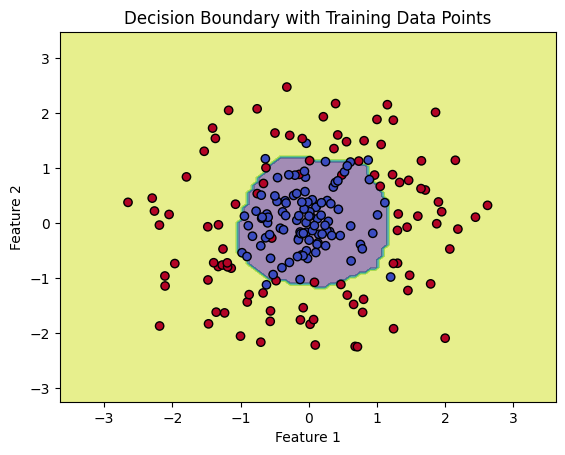

In [ ]:
m.decision_boundary(train_features, encoded_train_labels)